In [56]:
# Ensure these are installed, else might fail silently
suppressMessages(library(DESeq2))
suppressMessages(library(pheatmap))
suppressMessages(library(ggplot2))
suppressMessages(library(cowplot))
suppressMessages(library(ggrepel))
suppressMessages(library(riborex))
suppressMessages(library(data.table))
suppressMessages(library(tximport))
suppressMessages(library(dplyr))
suppressMessages(library(sleuth))
library(tidyverse)


'%notin%' <- function(x,y)!('%in%'(x,y))
cbbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
#gene_annotation_file <- '/home/cmb-panasas2/skchoudh/genomes/hg38/annotation/hg38_gene_names_stripped.tsv'
#gene_annotations <- read.table(gene_annotation_file,  col.names = c('id', 'name', 'type'), stringsAsFactors = F)
#rownames(gene_annotations) <- gene_annotations$id
colors <- list(species = c(
                'GRCh38' = cbbPalette[5],
                'panTro3' = cbbPalette[6],
                'Mmul8' = cbbPalette[7]),
               assay =  c('ribo' = cbbPalette[2],
                          'rna' = cbbPalette[3]))



write_results <- function(df, prefix){
  df<- as.data.frame(df)
  df <- df[order(df$padj),]
  #df$gene_name <- gene_annotations[rownames(df),]$name
  #df$gene_type <- gene_annotations[rownames(df),]$type

  df.sig <- subset(df, padj<0.05)
  df.sig.up <- subset(df.sig, log2FoldChange>0)
  df.sig.down <- subset(df.sig, log2FoldChange<0)
  write.table(df, file = file.path(results.dir,
                                   paste(prefix, 'tsv', sep='.')), sep = '\t')

  write.table(df.sig, file = file.path(results.dir,
                                   paste(prefix, 'sig', 'tsv', sep='.')), sep = '\t')
  write.table(df.sig.up,  file = file.path(results.dir,
                                       paste(prefix, 'sig', 'up', 'tsv', sep='.')), sep = '\t')
  write.table(df.sig.down,  file = file.path(results.dir,
                                         paste(prefix, 'sig', 'down', 'tsv', sep='.')), sep = '\t')
  return (df.sig)
}

ERROR: Error in library(tidyverse): there is no package called ‘tidyverse’


In [2]:
plotHeatMap <- function(rlogdist, filename=NULL){
  sampleDists <- dist(t(assay(rlogdist)))
  sampleDistMatrix <- as.matrix(sampleDists)
  rownames(sampleDistMatrix) <- colnames(rlogdist)#paste(rlogdist$condition, colnames(rlogdist), sep="-")
  colnames(sampleDistMatrix) <- NULL
  colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
  pheatmap(sampleDistMatrix,
           clustering_distance_rows=sampleDists,
           cellwidth=10,
           cellheight=10,
          clustering_distance_cols=sampleDists,
           col=colors,)
  if (!is.null(filename)) {
      pheatmap(sampleDistMatrix,
               cellwidth=20,
               cellheight=20,
               clustering_distance_rows=sampleDists,
               clustering_distance_cols=sampleDists,
               col=colors, filename=filename)
  }
}

In [3]:
read_featurecounts <- function(filepath){
    counts.data <- read.table(filepath,
                              row.names=1,
                              stringsAsFactors = F,
                              header = T)
    counts.data <- counts.data[ , 6:ncol(counts.data)]
    rownames(counts.data) <- gsub('\\.[0-9]+', '', rownames(counts.data))
    # Remove .bam or .sam from filenames
    colnames(counts.data) <- gsub("\\.[sb]am$", "", colnames(counts.data))
    colnames(counts.data) <- gsub("bams_unique\\.", "", colnames(counts.data))
    return (counts.data)

}

# Read ortho tables

In [72]:
head(orthologs.rheMac8)

,Gene.stable.ID,Macaque.gene.stable.ID,Macaque.homology.type
34799,ENSG00000000003,ENSMMUG00000008209,ortholog_one2one
34800,ENSG00000000003,ENSMMUG00000008209,ortholog_one2one
34801,ENSG00000000003,ENSMMUG00000008209,ortholog_one2one
34802,ENSG00000000003,ENSMMUG00000008209,ortholog_one2one
34803,ENSG00000000003,ENSMMUG00000008209,ortholog_one2one
33671,ENSG00000000005,ENSMMUG00000008212,ortholog_one2one


In [73]:
orthologs.rheMac8 <- orthologs.rheMac8[!duplicated(orthologs.rheMac8), ]
length(orthologs.rheMac8$Gene.stable.ID)

[1] 19672

In [75]:
length(orthologs.rheMac8$Gene.stable.ID)

[1] 19672

In [76]:
length(orthologs.panTro3$Gene.stable.ID)

[1] 21762

In [4]:
metadata.rna <- read.csv('../data/ortho-datasets-metadata/SRP028612_metadata.tsv',
                         header=T,
                         stringsAsFactors=F,
                         sep='\t')
rownames(metadata.rna) <- metadata.rna$experiment_accession
head(metadata.rna)

,experiment_accession,cell_line,species,sex,assay
SRX333018,SRX333018,PT91,panTro3,male,rna
SRX333019,SRX333019,S004973,panTro3,male,rna
SRX333020,SRX333020,S003659,panTro3,female,rna
SRX333021,SRX333021,AG18359,panTro3,female,rna
SRX333022,SRX333022,AG18358,panTro3,female,rna
SRX333023,SRX333023,R181-96,Mmul8,male,rna


In [5]:
metadata.ribo <- read.csv('../data/ortho-datasets-metadata/SRP062129_metadata.tsv',
                         header=T,
                         stringsAsFactors=F,
                         sep='\t')
rownames(metadata.ribo) <- metadata.ribo$experiment_accession
head(metadata.ribo)

,experiment_accession,cell_line,species,sex,assay
SRX1135820,SRX1135820,Min18358,panTro3,female,ribo
SRX1135821,SRX1135821,Min18358,panTro3,female,ribo
SRX1135822,SRX1135822,NS03659,panTro3,female,ribo
SRX1135823,SRX1135823,NS04973,panTro3,male,ribo
SRX1135824,SRX1135824,Pt91,panTro3,male,ribo
SRX1135825,SRX1135825,150-99,Mmul8,female,ribo


In [6]:
counts.GRCh38.rna <- read_featurecounts('/staging/as/skchoudh/re-ribo-analysis/hg38/SRP028612/featureCounts_CDS/fcounts.tsv')
counts.GRCh38.ribo <- read_featurecounts('/staging/as/skchoudh/re-ribo-analysis/hg38/SRP062129/featureCounts_CDS/fcounts.tsv')

counts.GRCh38 <- cbind(counts.GRCh38.rna, counts.GRCh38.ribo)


In [28]:
counts.panTro3.rna <- read_featurecounts('/staging/as/skchoudh/re-ribo-analysis/panTro3/SRP028612/featureCounts_CDS/fcounts.tsv')
counts.panTro3.ribo <- read_featurecounts('/staging/as/skchoudh/re-ribo-analysis/panTro3/SRP062129/featureCounts_CDS/fcounts.tsv')

counts.panTro3 <- cbind(counts.panTro3.rna, counts.panTro3.ribo)


In [29]:
head(counts.panTro3)

,SRX333018,SRX333019,SRX333020,SRX333021,SRX333022,SRX1135820,SRX1135821,SRX1135822,SRX1135823,SRX1135824
ENSPTRG00000047549,0,0,0,0,0,0,0,0,0,0
ENSPTRG00000050965,0,16,9,13,14,0,1,0,6,0
ENSPTRG00000049558,9,13,8,13,8,0,14,3,0,0
ENSPTRG00000050603,0,2,1,4,2,0,1,0,0,0
ENSPTRG00000043702,0,0,0,0,0,0,0,0,0,0
ENSPTRG00000039445,0,1,0,0,0,0,1,6,0,0


In [31]:
counts.rheMac8.rna <- read_featurecounts('/staging/as/skchoudh/re-ribo-analysis/Mmul8/SRP028612/featureCounts_CDS/fcounts.tsv')
counts.rheMac8.ribo <- read_featurecounts('/staging/as/skchoudh/re-ribo-analysis/Mmul8/SRP062129/featureCounts_CDS/fcounts.tsv')

counts.rheMac8 <- cbind(counts.rheMac8.rna, counts.rheMac8.ribo)
head(counts.rheMac8)

,SRX333023,SRX333024,SRX333025,SRX333026,SRX333027,SRX1135825,SRX1135826,SRX1135827,SRX1135828,SRX1135829
ENSMMUG00000005947,117,177,214,91,61,39,115,138,25,27
ENSMMUG00000015800,4029,2677,4039,2459,3622,2252,2781,2848,2264,2163
ENSMMUG00000015802,127,292,167,253,130,39,56,78,107,36
ENSMMUG00000015804,43,139,42,61,56,10,31,88,48,69
ENSMMUG00000022525,0,1,1,1,0,1,0,0,0,0
ENSMMUG00000008350,1,0,0,0,0,0,0,0,0,0


In [7]:
metadata.GRCh38.rna<- subset(metadata.rna, metadata.rna$species=="GRCh38")
metadata.GRCh38.ribo <- subset(metadata.ribo, metadata.ribo$species=="GRCh38")
metadata.GRCh38 <- rbind(metadata.GRCh38.rna, metadata.GRCh38.ribo)
metadata.GRCh38$sex <- factor(metadata.GRCh38$sex, levels=c("male", "female"))
metadata.GRCh38$assay <- factor(metadata.GRCh38$assay, levels=c("rna", "ribo"))
head(metadata.GRCh38)

In [25]:
metadata.rheMac8.rna<- subset(metadata.rna, metadata.rna$species=="Mmul8")
metadata.rheMac8.ribo <- subset(metadata.ribo, metadata.ribo$species=="Mmul8")
metadata.rheMac8 <- rbind(metadata.rheMac8.rna, metadata.rheMac8.ribo)
metadata.rheMac8$sex <- factor(metadata.rheMac8$sex, levels=c("male", "female"))
metadata.rheMac8$assay <- factor(metadata.rheMac8$assay, levels=c("rna", "ribo"))
head(metadata.rheMac8)

,experiment_accession,cell_line,species,sex,assay
SRX333023,SRX333023,R181-96,Mmul8,male,rna
SRX333024,SRX333024,265-95,Mmul8,male,rna
SRX333025,SRX333025,R249-97,Mmul8,male,rna
SRX333026,SRX333026,150-99,Mmul8,female,rna
SRX333027,SRX333027,R290-96,Mmul8,male,rna
SRX1135825,SRX1135825,150-99,Mmul8,female,ribo


In [24]:
metadata.panTro3.rna<- subset(metadata.rna, metadata.rna$species=="panTro3")
metadata.panTro3.ribo <- subset(metadata.ribo, metadata.ribo$species=="panTro3")
metadata.panTro3 <- rbind(metadata.panTro3.rna, metadata.panTro3.ribo)
metadata.panTro3$sex <- factor(metadata.panTro3$sex, levels=c("male", "female"))
metadata.panTro3$assay <- factor(metadata.panTro3$assay, levels=c("rna", "ribo"))
head(metadata.panTro3)

,experiment_accession,cell_line,species,sex,assay
SRX333018,SRX333018,PT91,panTro3,male,rna
SRX333019,SRX333019,S004973,panTro3,male,rna
SRX333020,SRX333020,S003659,panTro3,female,rna
SRX333021,SRX333021,AG18359,panTro3,female,rna
SRX333022,SRX333022,AG18358,panTro3,female,rna
SRX1135820,SRX1135820,Min18358,panTro3,female,ribo


estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


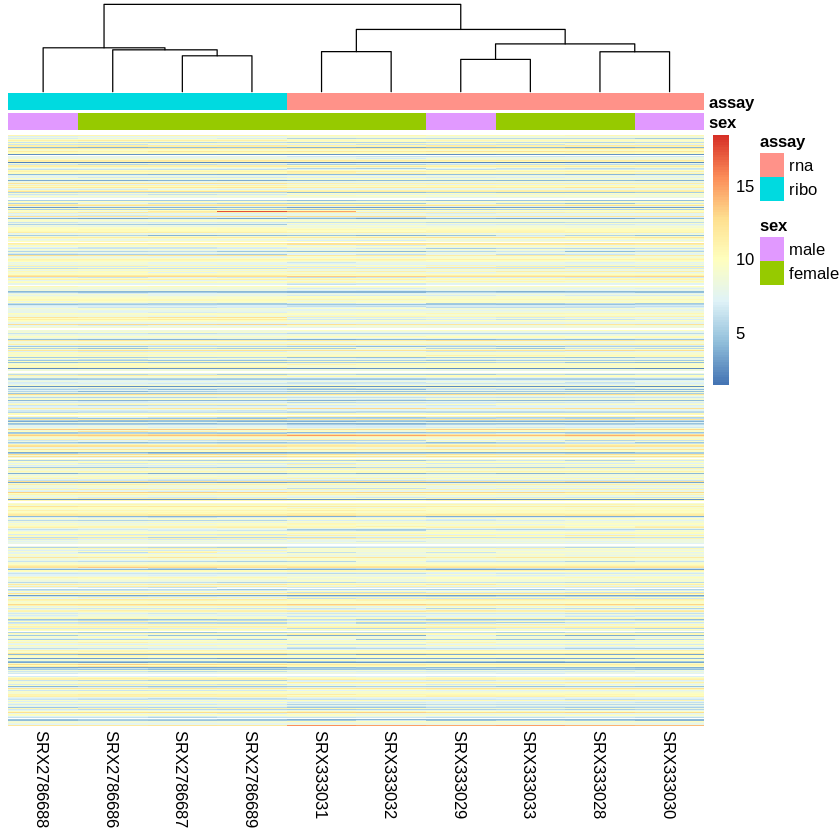

In [32]:
counts.GRCh38 <- counts.GRCh38[, metadata.GRCh38$experiment_accession]
sex <- metadata.GRCh38$sex
assay <- metadata.GRCh38$assay

coldata.GRCh38 <- data.frame(row.names=colnames(counts.GRCh38),
                             sex, assay)
dds.GRCh38 <- DESeqDataSetFromMatrix(countData=counts.GRCh38,
                                     colData=coldata.GRCh38,
                                     design=~sex+assay)
#dds <- dds.mouse[apply(counts(dds), 1, function(row) all(row !=0 )),]
dds.GRCh38 <- DESeq(dds.GRCh38)
dds.GRCh38 <- dds.GRCh38[apply(counts(dds.GRCh38), 1, 
                        function(row) all(row !=0 )),]
rld.GRCh38  <- rlogTransformation(dds.GRCh38 , blind=TRUE)
annotation.df <- as.data.frame(colData(dds.GRCh38)[, c("sex", "assay")])
rownames(annotation.df) <- rownames(colData(dds.GRCh38))
colnames(annotation.df) <- c("sex", "assay")
pheatmap(assay(rld.GRCh38), show_rownames = F, cluster_rows = F, annotation_col=annotation.df)

In [33]:
metadata.panTro3

,experiment_accession,cell_line,species,sex,assay
SRX333018,SRX333018,PT91,panTro3,male,rna
SRX333019,SRX333019,S004973,panTro3,male,rna
SRX333020,SRX333020,S003659,panTro3,female,rna
SRX333021,SRX333021,AG18359,panTro3,female,rna
SRX333022,SRX333022,AG18358,panTro3,female,rna
SRX1135820,SRX1135820,Min18358,panTro3,female,ribo
SRX1135821,SRX1135821,Min18358,panTro3,female,ribo
SRX1135822,SRX1135822,NS03659,panTro3,female,ribo
SRX1135823,SRX1135823,NS04973,panTro3,male,ribo
SRX1135824,SRX1135824,Pt91,panTro3,male,ribo


In [34]:
colnames(counts.panTro3)

[1] "SRX333018"  "SRX333019"  "SRX333020"  "SRX333021"  "SRX333022" 
 [6] "SRX1135820" "SRX1135821" "SRX1135822" "SRX1135823" "SRX1135824"

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


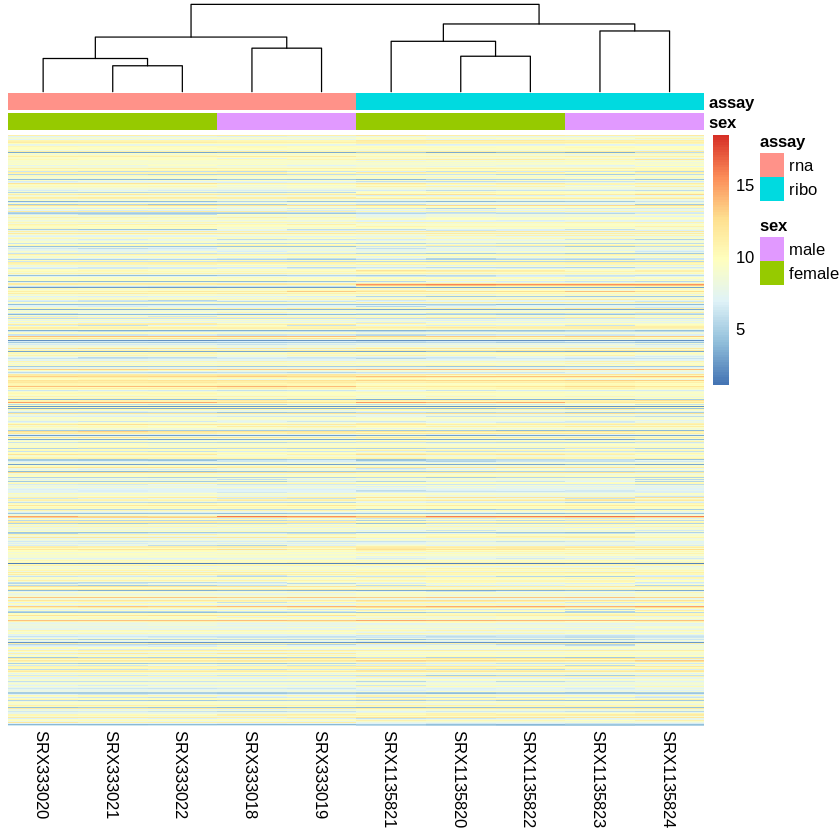

In [35]:
counts.panTro3 <- counts.panTro3[, metadata.panTro3$experiment_accession]
sex <- metadata.panTro3$sex
assay <- metadata.panTro3$assay

coldata.panTro3 <- data.frame(row.names=colnames(counts.panTro3),
                             sex, assay)
dds.panTro3 <- DESeqDataSetFromMatrix(countData=counts.panTro3,
                                     colData=coldata.panTro3,
                                     design=~sex+assay)
#dds <- dds.mouse[apply(counts(dds), 1, function(row) all(row !=0 )),]
dds.panTro3 <- DESeq(dds.panTro3)
dds.panTro3 <- dds.panTro3[apply(counts(dds.panTro3), 1, 
                        function(row) all(row !=0 )),]
rld.panTro3  <- rlogTransformation(dds.panTro3 , blind=TRUE)
annotation.df <- as.data.frame(colData(dds.panTro3)[, c("sex", "assay")])
rownames(annotation.df) <- rownames(colData(dds.panTro3))
colnames(annotation.df) <- c("sex", "assay")
pheatmap(assay(rld.panTro3), show_rownames = F, cluster_rows = F, annotation_col=annotation.df)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


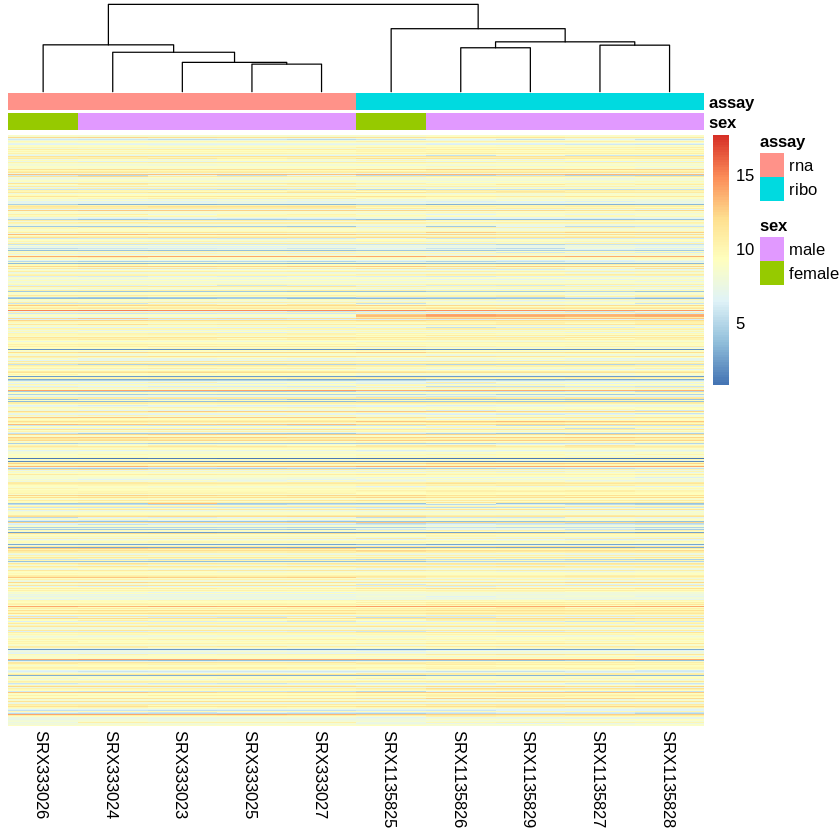

In [36]:
counts.rheMac8 <- counts.rheMac8[, metadata.rheMac8$experiment_accession]
sex <- metadata.rheMac8$sex
assay <- metadata.rheMac8$assay

coldata.rheMac8 <- data.frame(row.names=colnames(counts.rheMac8),
                             sex, assay)
dds.rheMac8 <- DESeqDataSetFromMatrix(countData=counts.rheMac8,
                                     colData=coldata.rheMac8,
                                     design=~sex+assay)
#dds <- dds.mouse[apply(counts(dds), 1, function(row) all(row !=0 )),]
dds.rheMac8 <- DESeq(dds.rheMac8)
dds.rheMac8 <- dds.rheMac8[apply(counts(dds.rheMac8), 1, 
                        function(row) all(row !=0 )),]
rld.rheMac8  <- rlogTransformation(dds.rheMac8 , blind=TRUE)
annotation.df <- as.data.frame(colData(dds.rheMac8)[, c("sex", "assay")])
rownames(annotation.df) <- rownames(colData(dds.rheMac8))
colnames(annotation.df) <- c("sex", "assay")
pheatmap(assay(rld.rheMac8), show_rownames = F, cluster_rows = F, annotation_col=annotation.df)

# Only using orthologs counts

In [208]:
orthologs.rheMac8 <- read.csv('../data//orthologs/human_macaque_ortholog.tsv', sep='\t', header=T, stringsAsFactors=F
                             )
orthologs.panTro3 <- read.csv('../data//orthologs/human_chimp_ortholog.tsv', sep='\t', header=T, stringsAsFactors=F)
#head(orthologs.rheMac8)
orthologs.rheMac8 <- subset(orthologs.rheMac8,  orthologs.rheMac8$Macaque.homology.type == 'ortholog_one2one')[, c("Gene.stable.ID", "Macaque.gene.stable.ID", "Macaque.homology.type")]
orthologs.panTro3 <- subset(orthologs.panTro3,  orthologs.panTro3$Chimpanzee.homology.type == 'ortholog_one2one')[, c("Gene.stable.ID", "Chimpanzee.gene.stable.ID", "Chimpanzee.homology.type")]

orthologs.rheMac8 <- orthologs.rheMac8[!duplicated(orthologs.rheMac8),]
orthologs.panTro3 <- orthologs.panTro3[!duplicated(orthologs.panTro3),]

orthologs.rheMac8 <- subset(orthologs.rheMac8, orthologs.rheMac8$Macaque.gene.stable.ID %in% rownames(counts.rheMac8))
orthologs.panTro3 <- subset(orthologs.panTro3, orthologs.panTro3$Chimpanzee.gene.stable.ID %in% rownames(counts.panTro3))



Gene.stable.ID,Chimpanzee.gene.stable.ID,Chimpanzee.homology.type


In [209]:
commonOrthologs <- intersect(orthologs.panTro3$Gene.stable.ID, orthologs.rheMac8$Gene.stable.ID)
commonOrthologs <- intersect(commonOrthologs, rownames(counts.GRCh38))

In [210]:
counts.GRCh38.subset <- counts.GRCh38[commonOrthologs,]
sum(is.na(counts.GRCh38.subset))

[1] 0

In [211]:
orthologs.panTro3

,Gene.stable.ID,Chimpanzee.gene.stable.ID,Chimpanzee.homology.type
1,ENSG00000198888,ENSPTRG00000042641,ortholog_one2one
2,ENSG00000198763,ENSPTRG00000042626,ortholog_one2one
4,ENSG00000198804,ENSPTRG00000042657,ortholog_one2one
5,ENSG00000198712,ENSPTRG00000042660,ortholog_one2one
6,ENSG00000228253,ENSPTRG00000042653,ortholog_one2one
7,ENSG00000198899,ENSPTRG00000042650,ortholog_one2one
8,ENSG00000198938,ENSPTRG00000042661,ortholog_one2one
9,ENSG00000198840,ENSPTRG00000042628,ortholog_one2one
14,ENSG00000198886,ENSPTRG00000042639,ortholog_one2one
15,ENSG00000198786,ENSPTRG00000042651,ortholog_one2one


In [212]:
orthologs.panTro3.subset <- subset(orthologs.panTro3, orthologs.panTro3$Gene.stable.ID %in% commonOrthologs)

orthologs.panTro3.subset <- orthologs.panTro3.subset[order(orthologs.panTro3.subset$Gene.stable.ID),] 

orthologs.rheMac8.subset <- subset(orthologs.rheMac8, orthologs.rheMac8$Gene.stable.ID %in% commonOrthologs)

orthologs.rheMac8.subset <- orthologs.rheMac8.subset[order(orthologs.rheMac8.subset$Gene.stable.ID),] 


In [213]:
dim(orthologs.panTro3.subset)

[1] 14479     3

In [214]:
dim(orthologs.rheMac8.subset)

[1] 14479     3

In [217]:
counts.GRCh38.subset <- counts.GRCh38[rownames(counts.GRCh38) %in% orthologs.panTro3.subset$Gene.stable.ID,]
head(counts.GRCh38.subset)

,SRX333028,SRX333029,SRX333030,SRX333031,SRX333032,SRX333033,SRX2786686,SRX2786687,SRX2786688,SRX2786689
ENSG00000187642,1,2,1,0,0,1,0,0,1,0
ENSG00000237330,2,0,0,0,0,2,4,0,0,0
ENSG00000131591,98,142,130,107,105,167,55,55,39,86
ENSG00000162571,0,0,2,0,0,0,0,0,0,0
ENSG00000186891,42,176,45,127,199,93,123,70,44,57
ENSG00000078808,1851,1739,1995,1280,1636,1449,1126,1156,1405,1584


In [218]:
counts.GRCh38.subset <- counts.GRCh38[rownames(counts.GRCh38) %in% orthologs.panTro3.subset$Gene.stable.ID,]
counts.GRCh38.subset <- counts.GRCh38.subset[order(rownames(counts.GRCh38.subset)),]
cat(sum(is.na(counts.GRCh38.subset)))
cat("\n")
counts.panTro3.subset <- counts.panTro3[rownames(counts.panTro3) %in% orthologs.panTro3.subset$Chimpanzee.gene.stable.ID,]
rownames(counts.panTro3.subset) <- rownames(counts.GRCh38.subset)
cat(sum(is.na(counts.panTro3.subset)))
cat("\n")


counts.rheMac8.subset <- counts.rheMac8[rownames(counts.rheMac8) %in% orthologs.rheMac8.subset$Macaque.gene.stable.ID,]
rownames(counts.rheMac8.subset) <- rownames(counts.GRCh38.subset)
cat(sum(is.na(counts.rheMac8.subset)))
cat("\n")

dim(counts.GRCh38.subset)

0
0
0


[1] 14479    10

In [219]:
counts.subset <- cbind(counts.panTro3.subset, counts.GRCh38.subset, counts.rheMac8.subset)
head(counts.subset)

,SRX333018,SRX333019,SRX333020,SRX333021,SRX333022,SRX1135820,SRX1135821,SRX1135822,SRX1135823,SRX1135824,⋯,SRX333023,SRX333024,SRX333025,SRX333026,SRX333027,SRX1135825,SRX1135826,SRX1135827,SRX1135828,SRX1135829
ENSG00000000003,0,1,1,0,0,0,18,0,0,1,⋯,0,1,1,1,0,1,0,0,0,0
ENSG00000000005,70,72,59,81,82,17,0,48,18,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,0,2,8,2,7,0,13,0,0,0,⋯,57,53,58,92,43,26,91,0,2,43
ENSG00000000457,55,2139,538,571,559,75,605,767,642,42,⋯,0,1,0,2,1,0,0,0,0,14
ENSG00000000460,1223,1948,1367,2039,1814,563,1771,1884,1023,1537,⋯,2,12,3,12,3,14,0,0,20,6
ENSG00000001036,78,92,68,127,148,36,403,309,158,261,⋯,1942,2007,1705,1902,2188,1489,2079,1399,1351,1732


In [220]:
metadata.rna.ribo <- rbind(metadata.rna, metadata.ribo)
metadata.rna.ribo$sex <- factor(metadata.rna.ribo$sex, levels=c("male", "female"))
metadata.rna.ribo$assay <- factor(metadata.rna.ribo$assay, levels=c("rna", "ribo"))
metadata.rna.ribo$species <- factor(metadata.rna.ribo$species, levels=c("GRCh38", "panTro3", "Mmul8"))

head(metadata.rna.ribo)

,experiment_accession,cell_line,species,sex,assay
SRX333018,SRX333018,PT91,panTro3,male,rna
SRX333019,SRX333019,S004973,panTro3,male,rna
SRX333020,SRX333020,S003659,panTro3,female,rna
SRX333021,SRX333021,AG18359,panTro3,female,rna
SRX333022,SRX333022,AG18358,panTro3,female,rna
SRX333023,SRX333023,R181-96,Mmul8,male,rna


In [221]:
counts.rna.ribo <- counts.subset[, metadata.rna.ribo$experiment_accession]
sex <- metadata.rna.ribo$sex
assay <- metadata.rna.ribo$assay
species <- metadata.rna.ribo$species

coldata.rna.ribo <- data.frame(row.names=colnames(counts.rna.ribo),
                             sex, assay, species)
dds.rna.ribo <- DESeqDataSetFromMatrix(countData=counts.rna.ribo,
                                     colData=coldata.rna.ribo,
                                     design=~sex+assay+species)


estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
rlog() may take a few minutes with 30 or more samples,
vst() is a much faster transformation
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.


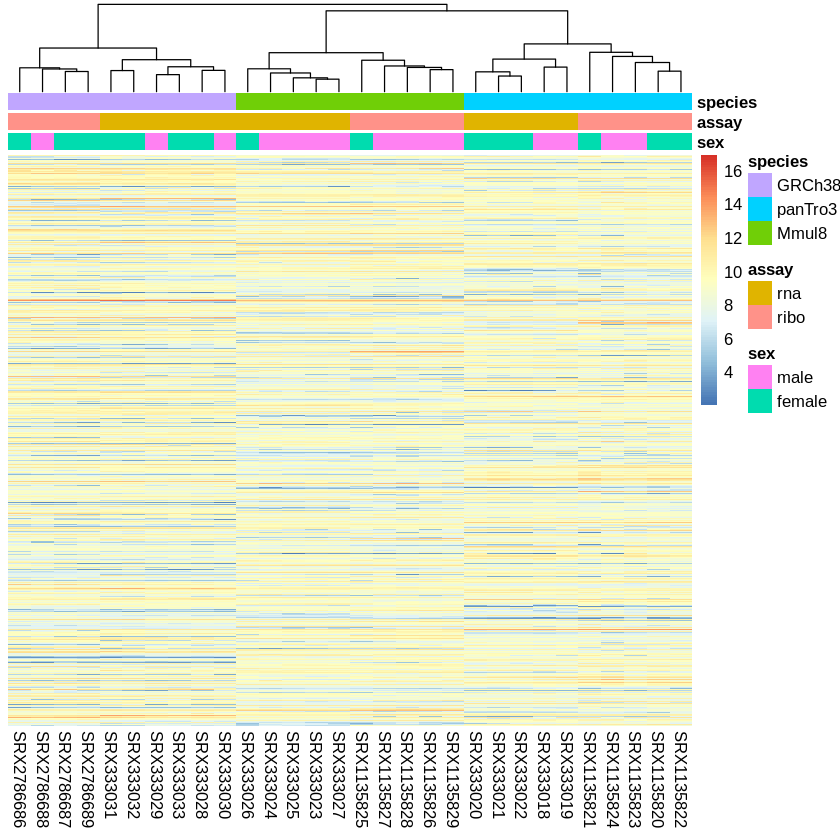

In [223]:
dds.rna.ribo <- DESeq(dds.rna.ribo)
dds.rna.ribo <- dds.rna.ribo[apply(counts(dds.rna.ribo), 1, 
                        function(row) all(row !=0 )),]
rld.rna.ribo  <- rlogTransformation(dds.rna.ribo , blind=TRUE)
annotation.df <- as.data.frame(colData(dds.rna.ribo)[, c("sex", "assay", "species")])
rownames(annotation.df) <- rownames(colData(dds.rna.ribo))
colnames(annotation.df) <- c("sex", "assay", "species")
pheatmap(assay(rld.rna.ribo), show_rownames = F, cluster_rows = F, annotation_col=annotation.df)